# Rat 05 forward model with linear elasticity

In [2]:
%matplotlib inline
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import os
import le

# Create mesh and define function spaces
mesh = Mesh("./mouse-data/rat3gmsh.xml")
cf = MeshFunction("size_t",mesh,"./mouse-data/rat3gmsh_physical_region.xml")
V = VectorFunctionSpace(mesh, 'P', 1)
W = FunctionSpace(mesh, 'P',1) # Function space for tumor cells

# Define initial fraction of tumor cells
# phi_0 = Expression('exp(-a*pow(x[0], 2) - a*pow(x[1], 2))', 
#                  degree=2, a=5)
# phi_n = interpolate(phi_0, W)
# plt.figure()
# plot(phi_n,title="Initial tumor cell concentration")

# Variables
mu = 1.0
lam = 1.0
nu = lam/(2*(lam+mu))
beta = .001
omega = 2*mu*beta+3*lam*beta

# Define boundary condition
def boundary(x, on_boundary):
    return on_boundary
bc = DirichletBC(V, Constant((0.0,0.0)), boundary)

T = Expression((('0','0'),('0','0')),degree=1)
n = FacetNormal(mesh)

# Compare with alternative formulation
u = le.varprob1(V, W, T, n, bc, phi_n, mu, lam, beta)
vm = le.vm1(u,mu,lam,beta, phi_n, W)

# Plot solution
plt.figure()
plot(u, title='Displacement', mode='displacement')

# Plot stress
plt.figure()
plot(vm, title='Stress intensity')

# Compute magnitude of displacement
plt.figure()
u_magnitude = sqrt(dot(u, u))
u_magnitude = project(u_magnitude, W)
plot(u_magnitude, title='Displacement magnitude')

# Save solution to file in VTK format
os.system('rm ./output/elasticity/*')
ufile = XDMFFile('./output/elasticity/disp.xdmf')
u.rename("disp","")
ufile.write(u,0)
del ufile

--- Instant: compiling ---


NameError: name 'phi_n' is not defined

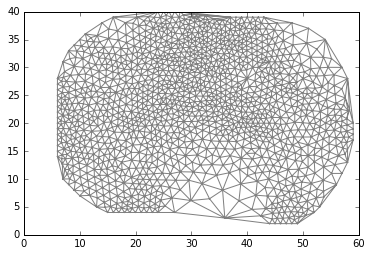

In [3]:
plot(mesh)